In [394]:
# Import necessary packages
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

In [395]:
df = pd.read_csv('diabetic_data.csv')

In [396]:
df.shape

(101766, 50)

# Mapping Admission, Discharge & Admission Source Types

In [397]:
mapping = pd.read_csv('IDs_mapping.csv')

In [398]:
admission_type_map = mapping[:8]
discharge_type_map = mapping[10:40]
admission_source_map = mapping[42:]
discharge_type_map.columns = ['discharge_disposition_id','description']
admission_source_map.columns = ['admission_source_id', 'description']

In [399]:
discharge_type_map.head()

,discharge_disposition_id,description
10,1,Discharged to home
11,2,Discharged/transferred to another short term h...
12,3,Discharged/transferred to SNF
13,4,Discharged/transferred to ICF
14,5,Discharged/transferred to another type of inpa...


# Data Cleaning & Exploratory analysis

In [400]:
# Removing discharge codes 11 (Expired), 13-14 (Hospice care), 19-21 (Expired)
terminally_ill = [11,13,14,19,21]
df = df[~df['discharge_disposition_id'].isin(terminally_ill)]

In [401]:
# Removing NaN & Not mapped values
df = df[~df['admission_type_id'].isin([6,8])]
df = df[~df['admission_source_id'].isin([17,20])]
df = df[~df['discharge_disposition_id'].isin([25])]

In [402]:
# Replacing values into 0 for no change and 1 for change 
df.change = df.change.replace(to_replace = 'Ch', value = 1)
df.change = df.change.replace(to_replace = 'No', value = 0)

In [403]:
# Identifying duplicate patients

duplicates = df[df.patient_nbr.isin(df.patient_nbr[df.patient_nbr.duplicated()])].sort_values(by = 'patient_nbr')
duplicates[['patient_nbr', 'number_inpatient', 'readmitted']].head()

,patient_nbr,number_inpatient,readmitted
4780,135,1,>30
4267,135,0,<30
23623,1152,1,>30
24642,1152,2,NO
14180,1152,1,>30


In [404]:
# Number of repeated visits for patients
(df.patient_nbr.value_counts() > 1).sum()

14921

In [405]:
# Dropping identification columns
df.drop('patient_nbr', axis = 1, inplace= True) # Dropping identification column
df.drop('payer_code', axis = 1, inplace= True) # Dropping Insurance information

In [406]:
# Exploring medication values to drop columns containing no information based on value counts
medication = ['max_glu_serum', 'A1Cresult','metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone']

meds_df = df[medication].apply(pd.Series.value_counts)
meds_df

,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,...,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone
>200,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
>300,259.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
>7,NaN,3564.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
>8,NaN,7463.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Down,NaN,NaN,526.0,42.0,10.0,1.0,179.0,NaN,483.0,494.0,...,NaN,NaN,NaN,NaN,10750.0,6.0,NaN,NaN,NaN,NaN
No,NaN,NaN,71758.0,88526.0,89313.0,89910.0,85177.0,89983.0,78809.0,80527.0,...,89982.0,89955.0,89984.0,89984.0,41609.0,89294.0,89971.0,89983.0,89982.0,89983.0
None,89671.0,74241.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Norm,46.0,4716.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Steady,NaN,NaN,16738.0,1312.0,639.0,67.0,4328.0,1.0,10029.0,8241.0,...,2.0,28.0,NaN,NaN,27515.0,677.0,13.0,1.0,2.0,1.0
Up,NaN,NaN,962.0,104.0,22.0,6.0,300.0,NaN,663.0,722.0,...,NaN,1.0,NaN,NaN,10110.0,7.0,NaN,NaN,NaN,NaN


In [407]:
# Dropping encounter_id & medication with less than 2 varying values
df.drop(['encounter_id','metformin-pioglitazone','metformin-rosiglitazone',
         'glimepiride-pioglitazone','troglitazone','acetohexamide','examide','citoglipton'], axis =1, inplace= True)

> Many columns contain '?', None, Norm values which we decide to include in our data by replacing them into unambiguous values.

In [408]:
# Replacing '?' Values into appropriate values

df.weight = df.weight.replace(to_replace='?', value='Not specified') # Not specified for Weight
df.race = df.race.replace(to_replace='?', value='Not Specified') # 'Not specified for Race
df.medical_specialty = df.medical_specialty.replace(to_replace='?', value='Not specified') # 'Not specified' for Med.Specialty
df.max_glu_serum = df.max_glu_serum.replace(to_replace='None', value = 'Not measured') # According to https://www.hindawi.com/journals/bmri/2014/781670/tab1/
df.max_glu_serum = df.max_glu_serum.replace(to_replace='Norm', value = 'Normal') # To make it more readable
df.A1Cresult = df.A1Cresult.replace(to_replace='None', value = 'Not measured') # According to https://www.hindawi.com/journals/bmri/2014/781670/tab1/
df.A1Cresult = df.A1Cresult.replace(to_replace='Norm', value = 'Normal') # To make it more readable

# Target Variable: Setting Early (within 30 days) readmission to '1' 

In [409]:
# Checking for NA values in target variable
df.readmitted.isna().sum() 

0

In [410]:
# Combining > 30 days before readmission and No as one category
df.readmitted = df.readmitted.replace(to_replace='>30', value='0')
df.readmitted = df.readmitted.replace(to_replace='NO', value='0')
df.readmitted = df.readmitted.replace(to_replace='<30', value='1')

## Verifying if Class Imbalance exists for target variable

> The target variable identifying whether a patient was readmitted early (within 30 days) is imbalanced, 11% of patients were readmitted within 30 days.
To combat imbalanced data, we opted to **downsample** the 'No' category. This will allow us to achieve a balance ratio closer to 1:1 and improve our binary classification predictions.

In [411]:
# Checking for class imbalance
df.readmitted.value_counts(normalize = True)

0    0.885924
1    0.114076
Name: readmitted, dtype: float64

# Webscraping ICD-9 Codes & their descriptions

In [412]:
# Page to scrape
page = f'http://www.icd9data.com/2008/Volume1/default.htm'

# Make a get request to retrieve the page
html_page = requests.get(page)

# Pass the page content to beautiful soup for parsing
soup = BeautifulSoup(html_page.content, 'html.parser') 
pretty_soup = soup.prettify()

In [413]:
# Beautiful soup to retrieve ICD codes & description
icd9 = [li.text.split('  ') for li in soup.find('ul').find_all('li')]

In [414]:
# Converting diagnosis codes into dataframe
icd9_df = pd.DataFrame(icd9, columns = ['icd9_range', 'diagnosis_desc'])

# Creating a range of values for icd9 codes
icd9_df['icd9_range'] = list(icd9_df['icd9_range'].apply(lambda x: x.split('-')))

In [415]:
icd9_df

,icd9_range,diagnosis_desc
0,"[001, 139]",Infectious And Parasitic Diseases
1,"[140, 239]",Neoplasms
2,"[240, 279]","Endocrine, Nutritional And Metabolic Diseases,..."
3,"[280, 289]",Diseases Of The Blood And Blood-Forming Organs
4,"[290, 319]",Mental Disorders
5,"[320, 389]",Diseases Of The Nervous System And Sense Organs
6,"[390, 459]",Diseases Of The Circulatory System
7,"[460, 519]",Diseases Of The Respiratory System
8,"[520, 579]",Diseases Of The Digestive System
9,"[580, 629]",Diseases Of The Genitourinary System


In [416]:
# Function to map diagnosis codes to the description of group disease they belong to

def icd_map(code):
    
    # Special characters mapping
    if str(code)[0] == 'V':
        return icd9_df.diagnosis_desc.loc[17]
    elif str(code)[0] == 'E':
        return icd9_df.diagnosis_desc.loc[18]
    
    # Replacing question mark into No diagnosis
    elif str(code)[0] == '?':
        return 'No diagnosis'
    
    # Numerical codes mapping
    else:
        code = round(float(code),0)
        for i in range(0,19):
            if code in range(int(icd9_df.icd9_range[i][0]),int(icd9_df.icd9_range[i][1])+1):
                return icd9_df.diagnosis_desc[i]

In [417]:
# Feature Engineering - Mapping to ICD9 codes and merging to initial dataframe
df['diag1_desc'] = df['diag_1'].apply(icd_map)
df['diag2_desc'] = df['diag_2'].apply(icd_map)
df['diag3_desc'] = df['diag_3'].apply(icd_map)

In [418]:
# Diagnosis table
diagnosis = df[['diag1_desc','diag2_desc','diag3_desc']].apply(pd.Series.value_counts)
diagnosis

,diag1_desc,diag2_desc,diag3_desc
"Complications Of Pregnancy, Childbirth, And The Puerperium",663,409,292
Congential Anomalies,43,95,87
Diseases Of The Blood And Blood-Forming Organs,1016,2566,2202
Diseases Of The Circulatory System,26912,27729,26550
Diseases Of The Digestive System,8130,3478,3142
Diseases Of The Genitourinary System,4564,7169,5592
Diseases Of The Musculoskeletal System And Connective Tissue,4417,1603,1716
Diseases Of The Nervous System And Sense Organs,1100,1157,1562
Diseases Of The Respiratory System,8903,8782,5825
Diseases Of The Skin And Subcutaneous Tissue,2257,3264,2213


In [419]:
# Dropping ICD9 code columns as they are now grouped
df = df.drop(['diag_1','diag_2','diag_3'],axis =1)

In [420]:
df.shape

(89984, 40)

Grouping drugs by drug class

In [421]:
# create a dictionary with the different medication families for each diabetes drug so that
# we can manipulate these columns and narrow down the amount of features we are using
drug_classes = {'biguanides' : ['metformin', 'glyburide-metformin', 'glipizide-metformin'], 
                'meglitinides':['repaglinide','nateglinide'], 
                'sulfonylureas': ['chlorpropamide','glimepiride','glipizide', 'glyburide','tolbutamide', 'tolazamide','glyburide-metformin', 'glipizide-metformin'], 
                'thiazolidinediones': ['pioglitazone','rosiglitazone'], 
                'alpha_glucosidase_inhibitors': ['acarbose', 'miglitol'], 
                'insulins': ['insulin']}

#Create dictionarty with our keys as the data found in our medication columns and the values of each key as a Bool  
replaced = {'Steady': True, 'Up': True, 'Down': True, 'No': False} 


#Iterate through and classify our patients as either on our off each medication, by changing our values for 'Down, Up, Steady' to True and our value for 'No' as False
for column in df.iloc[:,18:34]:
    df[column] = df[column].replace(to_replace = replaced, value = None)

In [422]:
# need to create new dummy variable column for each drug class family and 
# have it equal true if the individual is on a medication for any drug within that family

df['biguanides'] = df[(df['metformin'] == True) | (df['glyburide-metformin'] == True) | (df['glipizide-metformin'] == True)].any(axis=1)
df['biguanides'] = df['biguanides'].fillna(False) 


# create a conditional statement
df['meglitinides'] = df[(df['repaglinide'] == True) | (df['nateglinide'] == True)].any(axis=1)
df['meglitinides'] = df['meglitinides'].fillna(False) 


df['sulfonylureas'] = df[(df['chlorpropamide'] == True) | (df['glimepiride'] == True) | (df['glipizide']==True) | (df['glyburide'] == True) | (df['tolbutamide'] == True) | (df['tolazamide'] == True) | (df['glyburide-metformin'] == True) | (df['glipizide-metformin'] == True)].any(axis=1) 
df['sulfonylureas'] = df['sulfonylureas'].fillna(False)                                                            
                                            

df['thiazolidinediones'] = df[(df['pioglitazone'] == True) | (df['rosiglitazone'] == True) | (df['glipizide'] == True)].any(axis=1)
df['thiazolidinediones'] = df['thiazolidinediones'].fillna(False)     


df['alpha_glucosidase_inhibitors'] = df[(df['acarbose'] == True) | (df['miglitol'] == True)].any(axis=1)
df['alpha_glucosidase_inhibitors'] = df['alpha_glucosidase_inhibitors'].fillna(False)


df['insulins'] = df[(df['insulin'] == True)].any(axis=1) 
df['insulins'] = df['insulins'].fillna(False)  


df = df.drop(df.iloc[:,18:34], axis =1)


Cleaning Medical specialty column

In [423]:
# Identifying Top 10 medical specialties, will group all other specialties into 'Other' category
df.medical_specialty.value_counts() > 500

Not specified                            True
InternalMedicine                         True
Emergency/Trauma                         True
Family/GeneralPractice                   True
Cardiology                               True
Surgery-General                          True
Orthopedics                              True
Nephrology                               True
Radiologist                              True
Orthopedics-Reconstructive               True
Psychiatry                               True
Pulmonology                              True
Surgery-Cardiovascular/Thoracic          True
ObstetricsandGynecology                  True
Urology                                  True
Surgery-Vascular                        False
Gastroenterology                        False
Surgery-Neuro                           False
PhysicalMedicineandRehabilitation       False
Oncology                                False
Pediatrics                              False
Neurology                         

In [424]:
#create a list for our top 10 professions which will allow us to group all of our other values into "Other" 
medprofessions = ['Not specified', 'InternalMedicine', 'Emergency/Trauma', 'Family/GeneralPractice', 'Cardiology', 'Surgery-General', 'Orthopedics', 'Nephrology', 'Radiologist', 'Orthopedics-Reconstructive']


#replace all values in medical_specialty column that are not considered the most common with the value 'Other'
df.loc[~df.medical_specialty.isin(medprofessions), 'medical_specialty'] = 'Other'

Correlation Heatmap

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5]),
 <a list of 18 Text yticklabel objects>)

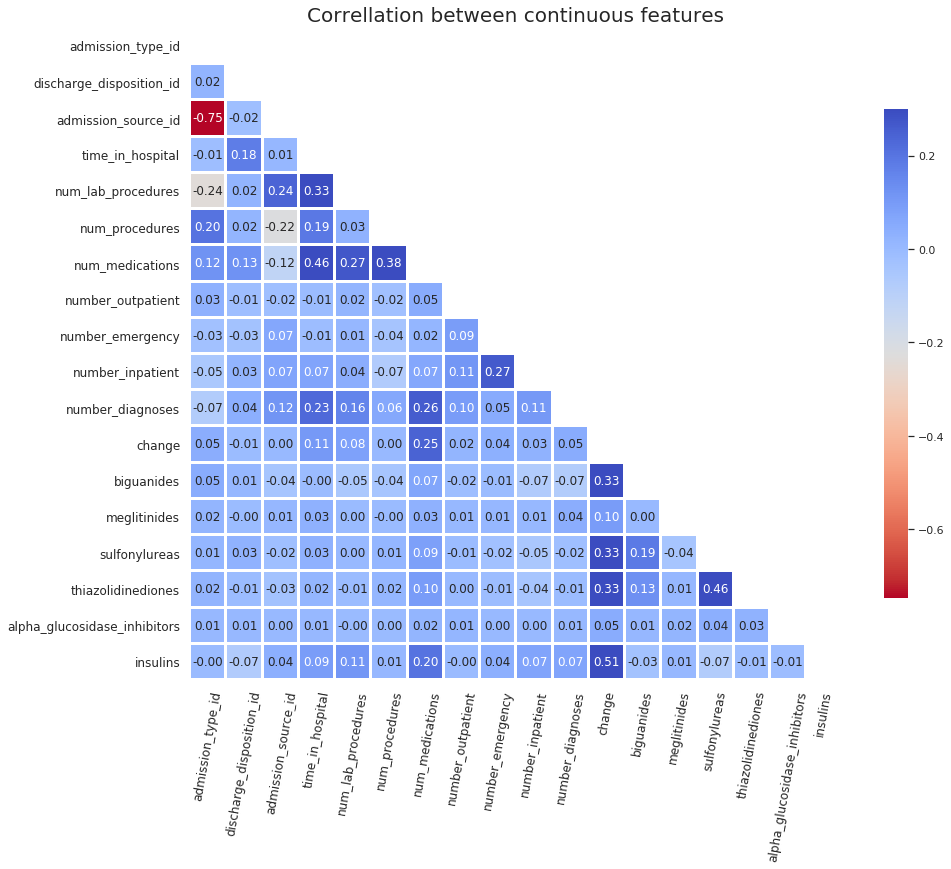

In [425]:
# Correlation heatmap
mask = np.zeros_like(df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.set(style="white")

plt.figure(figsize=(15,12))

sns.heatmap(df.corr(),mask=mask, annot= True, vmax=.3,cmap = 'coolwarm_r', square=True, fmt='.2f',
            linewidths=2, cbar_kws={"shrink": 0.75})
plt.title('Correllation between continuous features', size = 20)
plt.xticks(rotation=80, size = 12)
plt.yticks(size = 12)

# Label Encoding for Categorical Data

> Race, Gender, Age, Weight, Payer_code, Diag1_desc, Diag2_desc, Diag3_desc, Maxglu_serum, A1Cresult, Change, DiabetesMed, Medical specialty. Target variable (Readmitted) was changed manually.

In [426]:
df1 = df.copy(deep=True)

Function to identify which diseases were present for each patient by encoding each of disease classifications as dummy columns.

In [427]:
def make_col_diagnosis(diagnosis):
    df1[diagnosis] = df1[(df1['diag1_desc'] == diagnosis) | (df1['diag2_desc'] == diagnosis)
                       | (df1['diag3_desc'] == diagnosis)].any(axis=1)
    df1[diagnosis] = df1[diagnosis].fillna(False)

In [428]:
for diag in diagnosis.T.columns.tolist():
    make_col_diagnosis(diag)

In [429]:
df1.drop(['diag1_desc','diag2_desc','diag3_desc'], axis = 1)

,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,...,Diseases Of The Skin And Subcutaneous Tissue,"Endocrine, Nutritional And Metabolic Diseases, And Immunity Disorders",Infectious And Parasitic Diseases,Injury And Poisoning,Mental Disorders,Neoplasms,No diagnosis,Supplementary Classification Of External Causes Of Injury And Poisoning,Supplementary Classification Of Factors Influencing Health Status And Contact With Health Services,"Symptoms, Signs, And Ill-Defined Conditions"
1,Caucasian,Female,[10-20),Not specified,1,1,7,3,Not specified,59,...,False,True,False,False,False,False,False,False,False,False
2,AfricanAmerican,Female,[20-30),Not specified,1,1,7,2,Not specified,11,...,False,True,False,False,False,False,False,False,True,False
3,Caucasian,Male,[30-40),Not specified,1,1,7,2,Not specified,44,...,False,True,True,False,False,False,False,False,False,False
4,Caucasian,Male,[40-50),Not specified,1,1,7,1,Not specified,51,...,False,True,False,False,False,True,False,False,False,False
5,Caucasian,Male,[50-60),Not specified,2,1,2,3,Not specified,31,...,False,True,False,False,False,False,False,False,False,False
6,Caucasian,Male,[60-70),Not specified,3,1,2,4,Not specified,70,...,False,False,False,False,False,False,False,False,True,False
7,Caucasian,Male,[70-80),Not specified,1,1,7,5,Not specified,73,...,False,True,False,False,False,False,False,False,False,False
8,Caucasian,Female,[80-90),Not specified,2,1,4,13,Not specified,68,...,False,False,True,False,False,False,False,False,False,False
9,Caucasian,Female,[90-100),Not specified,3,3,4,12,InternalMedicine,33,...,False,False,False,False,False,True,False,False,False,False
10,AfricanAmerican,Female,[40-50),Not specified,1,1,7,9,Not specified,47,...,False,True,False,True,False,False,False,False,False,False


Label Encoding for Race, Gender, Change

In [430]:
# Label Encoder instance
lb = LabelEncoder()

In [431]:
# Categorical columns to encode label
cat_cols = ['race','gender']

In [433]:
# apply label encoding on Race, Gender, Change
df1[cat_cols] = df1[cat_cols].apply(lambda col: lb.fit_transform(col))

One-Hot Encoding for

In [434]:
df1.head()

,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,...,Diseases Of The Skin And Subcutaneous Tissue,"Endocrine, Nutritional And Metabolic Diseases, And Immunity Disorders",Infectious And Parasitic Diseases,Injury And Poisoning,Mental Disorders,Neoplasms,No diagnosis,Supplementary Classification Of External Causes Of Injury And Poisoning,Supplementary Classification Of Factors Influencing Health Status And Contact With Health Services,"Symptoms, Signs, And Ill-Defined Conditions"
1,2,0,[10-20),Not specified,1,1,7,3,Not specified,59,...,False,True,False,False,False,False,False,False,False,False
2,0,0,[20-30),Not specified,1,1,7,2,Not specified,11,...,False,True,False,False,False,False,False,False,True,False
3,2,1,[30-40),Not specified,1,1,7,2,Not specified,44,...,False,True,True,False,False,False,False,False,False,False
4,2,1,[40-50),Not specified,1,1,7,1,Not specified,51,...,False,True,False,False,False,True,False,False,False,False
5,2,1,[50-60),Not specified,2,1,2,3,Not specified,31,...,False,True,False,False,False,False,False,False,False,False
